In [4]:
import nltk
import torch
import random
import pandas as pd
from afinn import Afinn
from sklearn.model_selection import train_test_split
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from transformers import pipeline




In [2]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sharm\AppData\Roaming\nltk_data...


True

In [5]:
dataset = pd.read_csv('dataset.csv')

dataset

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [4]:
# Convert labels to binary
dataset['sentiment'] = dataset['sentiment'].apply(lambda x: 'positive' if x == 'positive' else 'negative')

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataset['review'], dataset['sentiment'], test_size=0.99)

# Initialize AFINN model
afinn = Afinn()

# Analyze sentiments for testing set
y_pred_test = [afinn.score(text) for text in X_test]

# Convert predicted scores to sentiment labels
y_pred_test = ['positive' if score >= 0 else 'negative' for score in y_pred_test]

# Calculate accuracy and F1 score on testing set
accuracy_test = accuracy_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test, pos_label='positive')

print(f'Testing accuracy: {accuracy_test:.3f}')
print(f'Testing F1 score: {f1_test:.3f}')


Testing accuracy: 0.702
Testing F1 score: 0.743


In [5]:
# Convert labels to binary
dataset['sentiment'] = dataset['sentiment'].apply(lambda x: 'positive' if x == 'positive' else 'negative')

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataset['review'], dataset['sentiment'], test_size=0.99)

# Initialize VADER model
vader = SentimentIntensityAnalyzer()

# Analyze sentiments for testing set
y_pred_test = [vader.polarity_scores(text)['compound'] for text in X_test]

# Convert predicted scores to sentiment labels
y_pred_test = ['positive' if score >= 0 else 'negative' for score in y_pred_test]

# Calculate accuracy and F1 score on testing set
accuracy_test = accuracy_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test, pos_label='positive')

print(f'Testing accuracy: {accuracy_test:.3f}')
print(f'Testing F1 score: {f1_test:.3f}')


Testing accuracy: 0.696
Testing F1 score: 0.738


In [6]:


# Convert labels to binary
dataset['sentiment'] = dataset['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataset['review'], dataset['sentiment'], test_size=0.2)

# Create bag of words vectors for training set
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)

# Train Naive Bayes model
nb = MultinomialNB()
nb.fit(X_train_vec, y_train)

# Create bag of words vectors for testing set
X_test_vec = vectorizer.transform(X_test)

# Predict sentiment labels for testing set
y_pred_test = nb.predict(X_test_vec)

# Calculate accuracy and F1 score on testing set
accuracy_test = accuracy_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

print(f'Testing accuracy: {accuracy_test:.3f}')
print(f'Testing F1 score: {f1_test:.3f}')


Testing accuracy: 0.848
Testing F1 score: 0.843


In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizerFast
from transformers import RobertaForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score, accuracy_score
import torch

# Load dataset
dataset = pd.read_csv('dataset.csv')
dataset = dataset.head(100)

dataset['sentiment'] = dataset['sentiment'].map({'positive': 1, 'negative': 0})

# Split data into train and test sets
train_df, test_df = train_test_split(dataset, test_size=0.2, random_state=42)

# Load Roberta tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

# Tokenize input text and create dataset
train_encodings = tokenizer(list(train_df['review']), truncation=True, padding=True)
test_encodings = tokenizer(list(test_df['review']), truncation=True, padding=True)

train_labels = list(train_df['sentiment'])
test_labels = list(test_df['sentiment'])

train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
                              torch.tensor(train_encodings['attention_mask']),
                              torch.tensor(train_labels))

test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']),
                             torch.tensor(test_encodings['attention_mask']),
                             torch.tensor(test_labels))

# Load Roberta model and set up training parameters
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Train model
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
epochs = 5
for epoch in range(epochs):
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optimizer.step()

# Evaluate model on test set and calculate F1 score
y_true = []
y_pred = []

for batch in test_loader:
    input_ids, attention_mask, labels = batch
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs[0]

    y_true.extend(labels.tolist())
    y_pred.extend(torch.argmax(logits, axis=1).tolist())

f1 = f1_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

print('F1 score: {:.3f}'.format(f1))
print('Accuracy: {:.3f}'.format(accuracy))


In [7]:
#combined code

import nltk
import torch
import random
import pandas as pd
from afinn import Afinn
from sklearn.model_selection import train_test_split
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from transformers import pipeline
from transformers import RobertaTokenizerFast
from torch.utils.data import DataLoader, TensorDataset



dataset = pd.read_csv('dataset.csv')

# Convert labels to binary
dataset['sentiment'] = dataset['sentiment'].apply(lambda x: 'positive' if x == 'positive' else 'negative')

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataset['review'], dataset['sentiment'], test_size=0.99) #using the enitre dataset to test for the performance metrics

# Initialize AFINN model
afinn = Afinn()

# Analyze sentiments for testing set
y_pred_test = [afinn.score(text) for text in X_test]

# Convert predicted scores to sentiment labels
y_pred_test = ['positive' if score >= 0 else 'negative' for score in y_pred_test]

# Calculate accuracy and F1 score on testing set
accuracy_test = accuracy_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test, pos_label='positive')

print(f'AFINN Testing accuracy: {accuracy_test:.3f}')
print(f'AFINN Testing F1 score: {f1_test:.3f}')


#for VADER

# Initialize VADER model
vader = SentimentIntensityAnalyzer()

# Analyze sentiments for testing set
y_pred_test = [vader.polarity_scores(text)['compound'] for text in X_test]

# Convert predicted scores to sentiment labels
y_pred_test = ['positive' if score >= 0 else 'negative' for score in y_pred_test]

# Calculate accuracy and F1 score on testing set
accuracy_test = accuracy_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test, pos_label='positive')

print(f'\n\nVader Testing accuracy: {accuracy_test:.3f}')
print(f'VADER Testing F1 score: {f1_test:.3f}')



#For NAIVE bayes


# Convert labels to binary
dataset['sentiment'] = dataset['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataset['review'], dataset['sentiment'], test_size=0.2)

# Create bag of words vectors for training set
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)

# Train Naive Bayes model
nb = MultinomialNB()
nb.fit(X_train_vec, y_train)

# Create bag of words vectors for testing set
X_test_vec = vectorizer.transform(X_test)

# Predict sentiment labels for testing set
y_pred_test = nb.predict(X_test_vec)

# Calculate accuracy and F1 score on testing set
accuracy_test = accuracy_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

print(f'\n\nNaive Testing accuracy: {accuracy_test:.3f}')
print(f'Naive Testing F1 score: {f1_test:.3f}')



#For ROberta

dataset = dataset.head(100)

dataset['sentiment'] = dataset['sentiment'].map({'positive': 1, 'negative': 0})

# Split data into train and test sets
train_df, test_df = train_test_split(dataset, test_size=0.2, random_state=42)

# Load Roberta tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

# Tokenize input text and create dataset
train_encodings = tokenizer(list(train_df['review']), truncation=True, padding=True)
test_encodings = tokenizer(list(test_df['review']), truncation=True, padding=True)

train_labels = list(train_df['sentiment'])
test_labels = list(test_df['sentiment'])

train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
                              torch.tensor(train_encodings['attention_mask']),
                              torch.tensor(train_labels))

test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']),
                             torch.tensor(test_encodings['attention_mask']),
                             torch.tensor(test_labels))

# Load Roberta model and set up training parameters
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Train model
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
epochs = 5
for epoch in range(epochs):
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optimizer.step()

# Evaluate model on test set and calculate F1 score
y_true = []
y_pred = []

for batch in test_loader:
    input_ids, attention_mask, labels = batch
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs[0]

    y_true.extend(labels.tolist())
    y_pred.extend(torch.argmax(logits, axis=1).tolist())

f1 = f1_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

print('\n\nF1 score: {:.3f}'.format(f1))
print('Accuracy: {:.3f}'.format(accuracy))


AFINN Testing accuracy: 0.703
AFINN Testing F1 score: 0.744
Vader Testing accuracy: 0.696
VADER Testing F1 score: 0.738
Naive Testing accuracy: 0.844
Naive Testing F1 score: 0.839


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

ValueError: Target size (torch.Size([16])) must be the same as input size (torch.Size([16, 2]))

In [1]:
#for afinn model

#for Afinn
import nltk
import torch
import random
import pandas as pd
from afinn import Afinn
from sklearn.model_selection import train_test_split
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from transformers import pipeline
from transformers import RobertaTokenizerFast
from torch.utils.data import DataLoader, TensorDataset



C:\Users\sharm\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = pd.read_csv('dataset.csv')

# Convert positive/negative to binary 1 and 0
dataset['sentiment'] = dataset['sentiment'].apply(lambda x: 'positive' if x == 'positive' else 'negative')

#Since this model doesn't require training I'm using the enitre dataset to test for the performance metrics
X_train, X_test, y_train, y_test = train_test_split(dataset['review'], dataset['sentiment'], test_size=0.20) 

# Initialize AFINN model
afinn = Afinn()

# Analyze sentiments for testing set
y_pred_test = [afinn.score(text) for text in X_test]

# Convert predicted scores to sentiment labels
y_pred_test = ['positive' if score >= 0 else 'negative' for score in y_pred_test]

# Calculate accuracy and F1 score on testing set
# accuracy_test = accuracy_score(y_test, y_pred_test)
# f1_test = f1_score(y_test, y_pred_test, pos_label='positive')

# print(f'AFINN Testing accuracy: {accuracy_test:.4f}')
# print(f'AFINN Testing F1 score: {f1_test:.4f}')


accuracy_test = accuracy_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test, pos_label='positive')
precision_test = precision_score(y_test, y_pred_test, pos_label='positive')
recall_test = recall_score(y_test, y_pred_test, pos_label='positive')
confusion_test = confusion_matrix(y_test, y_pred_test)


print(f'AFINN Testing accuracy: {accuracy_test:.4f}')
print(f'AFINN Testing F1 score: {f1_test:.4f}')
print(f'AFINN Testing precision: {precision_test:.4f}')
print(f'AFINN Testing recall: {recall_test:.4f}')
print(f'AFINN Testing confusion matrix:\n{confusion_test}')

AFINN Testing accuracy: 0.7062
AFINN Testing F1 score: 0.7468
AFINN Testing precision: 0.6563
AFINN Testing recall: 0.8662
AFINN Testing confusion matrix:
[[2730 2269]
 [ 669 4332]]


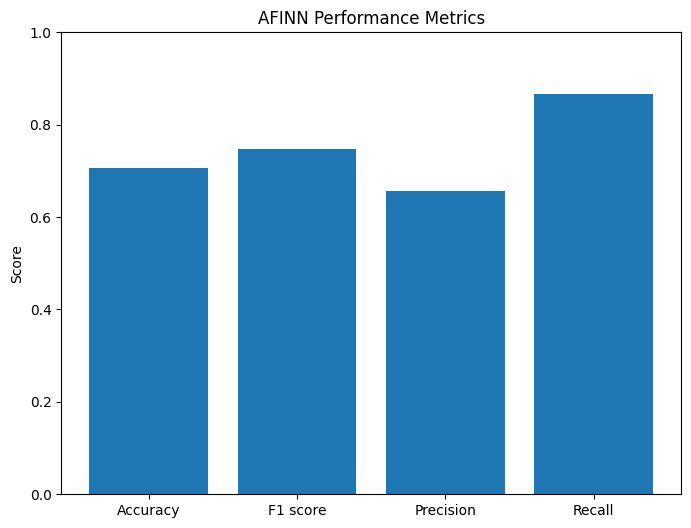

In [5]:
import matplotlib.pyplot as plt

# Plot performance metrics
fig, ax = plt.subplots(figsize=(8, 6))
metrics = ['Accuracy', 'F1 score', 'Precision', 'Recall']
scores = [accuracy_test, f1_test, precision_test, recall_test]
ax.bar(metrics, scores)
ax.set_ylim([0, 1])
ax.set_ylabel('Score')
ax.set_title('AFINN Performance Metrics')
plt.show()

In [7]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

classification_report_test = classification_report(y_test, y_pred_test)
print('AFINN Classification Report:\n', classification_report_test)

AFINN Classification Report:
               precision    recall  f1-score   support

    negative       0.80      0.55      0.65      4999
    positive       0.66      0.87      0.75      5001

    accuracy                           0.71     10000
   macro avg       0.73      0.71      0.70     10000
weighted avg       0.73      0.71      0.70     10000



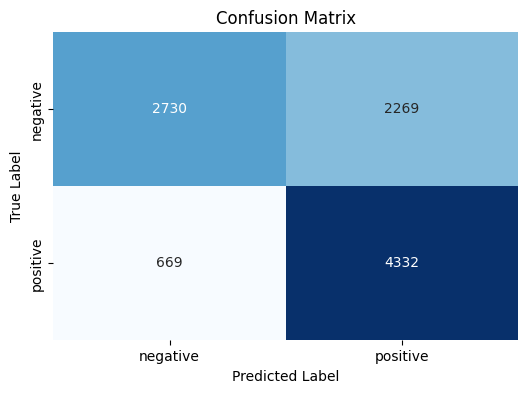

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(confusion_test, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.show()


In [12]:
#for VADER

# Initialize VADER model
vader = SentimentIntensityAnalyzer()

# Analyze sentiments for testing set
y_pred_test = [vader.polarity_scores(text)['compound'] for text in X_test]

# Convert predicted scores to sentiment labels
y_pred_test = ['positive' if score >= 0 else 'negative' for score in y_pred_test]

accuracy_test = accuracy_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test, pos_label='positive')
precision_test = precision_score(y_test, y_pred_test, pos_label='positive')
recall_test = recall_score(y_test, y_pred_test, pos_label='positive')
confusion_test = confusion_matrix(y_test, y_pred_test)
classification_report_test = classification_report(y_test, y_pred_test)



print(f'VADER Testing accuracy: {accuracy_test:.4f}')
print(f'VADER Testing F1 score: {f1_test:.4f}')
print(f'VADER Testing precision: {precision_test:.4f}')
print(f'VADER Testing recall: {recall_test:.4f}')
print(f'VADER Testing confusion matrix:\n{confusion_test}')
print('VADER Classification Report:\n', classification_report_test)


# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(confusion_test, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.show()

KeyboardInterrupt: 